In [1]:
#Trabalho final

#Análise da base de dados das Unidades Básicas de Saúde (UBS) existentes no território brasileiro

#Disciplina: Estatística Descritiva
#MBA de Ciência de Dados e IA da ENAP

#Aluna: Renata Rocha Torres Amaral
#Professor: Stefano Mozart

#Março/2025

In [ ]:
#Para esse trabalho, foi utilizada a base de dados, do Ministério da Saúde, de Unidades Básicas de Saúde por município e de população por município do IBGE (2023).
#Ambas as bases não possuem restrição de acesso ou dados sensíveis de acordo com a LGPD.

In [44]:
#Contextualização
#Uma Unidade Básica de Saúde (UBS) é a porta de entrada do Sistema Único de Saúde (SUS) no Brasil. 
#Sua principal função é oferecer atendimento primário à população, promovendo a prevenção, diagnóstico, tratamento e acompanhamento de doenças.
#As UBSs fazem parte da Atenção Primária à Saúde (APS) e são fundamentais para evitar que casos simples evoluam para problemas mais graves, reduzindo a demanda por hospitais.

#Nesse cenário, conhecer qual é a realidade brasileira, é fundamental para planejar políticas públicas.
#Sabe-se que hoje, o quantitativo de UBS é pequeno para atender toda a população do país. O Brasil é um país de grandes dimensões, com muitos municípios, e atender toda a população é um desafio para o poder público.
#Sabe-se também que, o orçamento público é limitado.]
#Assim, a ciência de dados tem muito a contribuir para que as tomadas de decisão sejam mais acertivas e que traga maiores benefícios para as pessoas.

#Portanto, o presente trabalho, tem o objetivo de analisar o quantitativo de UBSs existentes, fazendo uma correlação com a população do município.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gmean, hmean, skew, kurtosis, lognorm, kendalltau
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.regression.quantile_regression import QuantReg

In [46]:
#Importando a base de dados do Ministério da Saúde
# Definir o nome do arquivo CSV
arquivo_csv = "ubs_brasil.csv"

# Carregar o arquivo CSV em um DataFrame, tratando células em branco como NaN
try:
    df_ubs_brasil = pd.read_csv(
        arquivo_csv,
        encoding="utf-8",
        delimiter=';',  # Usar delimitador de ponto e vírgula
        decimal=',',  # Definir vírgula como separador decimal
        dtype={"CNES": str, "UF": str, "IBGE": str},  # Definir colunas como string
        na_values=['']  # Tratar células em branco como NaN
    )

     # Adicionar a coluna "qtd" com valor 1 para cada linha
    df_ubs_brasil["qtd"] = 1
    print("Arquivo carregado com sucesso!")
    display(df_ubs_brasil.head())  # Exibir as primeiras linhas do DataFrame
except FileNotFoundError:
    print(f"Erro: O arquivo '{arquivo_csv}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar o arquivo: {e}")

Arquivo carregado com sucesso!


,CNES,UF,IBGE,NOME,LOGRADOURO,BAIRRO,LATITUDE,LONGITUDE,qtd
0,0000302,26,260290,USF SANTO ESTEVAO,RUA DO CEMITERIO,PONTE DOS CARVALHOS,-8.21811,-35.22944,1
1,2376210,50,500240,ESTRATEGIA DE SAUDE DA FAMILIA MARIZA RODRIGUE...,RUA JOAO PESSOA,SANTO ANTONIO,-22.61912,-54.83528,1
2,2789310,35,355030,UBS VILA COSMOPOLITA,RUA CHUVAS DE VERAO,GUAIANASES,-23.56096,-46.42381,1
3,4613902,21,211060,POSTO MORRO DO SALTO DA PEDRA,POVOADO MORRO DO SALTO DA PEDRA,ZONA RURAL,-3.42166,-42.36826,1
4,4613910,21,211060,POSTO ENXU,POVOADO ENXU,ZONA RURAL,-3.32356,-42.58953,1


In [47]:
#Importanto a base de dados do IBGE
# Carregar o arquivo Excel, ignorando a primeira linha e tratando as colunas "COD. UF" e "COD. MUNIC" como string
df_pop = pd.read_excel("populacao.xls", dtype={"IBGE6": str, "IBGE7": str})

# Exibir as primeiras linhas para verificação
df_pop.head()

,REGIÃO,Sigla_Regiao,UF,COD. UF,COD. MUNIC,IBGE7,IBGE6,NOME DO MUNICÍPIO,MUN_UF,POP
0,Norte,N,RO,11,15,1100015,110001,Alta Floresta D'Oeste,Alta Floresta D'Oeste/RO,21494
1,Norte,N,RO,11,23,1100023,110002,Ariquemes,Ariquemes/RO,96833
2,Norte,N,RO,11,31,1100031,110003,Cabixi,Cabixi/RO,5351
3,Norte,N,RO,11,49,1100049,110004,Cacoal,Cacoal/RO,86887
4,Norte,N,RO,11,56,1100056,110005,Cerejeiras,Cerejeiras/RO,15890


In [48]:
#Unindo as duas bases para que seja possível fazer a correção do quantitativo de UBS e população
# Garantir que as colunas usadas na mesclagem sejam do tipo string
df_ubs_brasil["IBGE"] = df_ubs_brasil["IBGE"].astype(str)
df_pop["IBGE6"] = df_pop["IBGE6"].astype(str)

# Selecionar apenas a coluna desejada do df_pop
df_pop_selecionado = df_pop[["IBGE6", "POP", "UF", "REGIÃO", "MUN_UF"]]

# Mesclar os DataFrames usando as colunas "IBGE" e "IBGE6"
df_ubs = df_ubs_brasil.merge(df_pop_selecionado, left_on="IBGE", right_on="IBGE6", how="left")

# Garantir que a coluna 'pop' seja do tipo inteiro sem casa decimal
df_ubs["POP"] = pd.to_numeric(df_ubs["POP"], errors='coerce').fillna(0).astype(int)


# Exibir as primeiras linhas do DataFrame mesclado
df_ubs.head()



,CNES,UF_x,IBGE,NOME,LOGRADOURO,BAIRRO,LATITUDE,LONGITUDE,qtd,IBGE6,POP,UF_y,REGIÃO,MUN_UF
0,0000302,26,260290,USF SANTO ESTEVAO,RUA DO CEMITERIO,PONTE DOS CARVALHOS,-8.21811,-35.22944,1,260290,203440,PE,Nordeste,Cabo de Santo Agostinho/PE
1,2376210,50,500240,ESTRATEGIA DE SAUDE DA FAMILIA MARIZA RODRIGUE...,RUA JOAO PESSOA,SANTO ANTONIO,-22.61912,-54.83528,1,500240,30612,MS,Centro-Oeste,Caarapó/MS
2,2789310,35,355030,UBS VILA COSMOPOLITA,RUA CHUVAS DE VERAO,GUAIANASES,-23.56096,-46.42381,1,355030,11451999,SP,Sudeste,São Paulo/SP
3,4613902,21,211060,POSTO MORRO DO SALTO DA PEDRA,POVOADO MORRO DO SALTO DA PEDRA,ZONA RURAL,-3.42166,-42.36826,1,211060,26943,MA,Nordeste,São Bernardo/MA
4,4613910,21,211060,POSTO ENXU,POVOADO ENXU,ZONA RURAL,-3.32356,-42.58953,1,211060,26943,MA,Nordeste,São Bernardo/MA


In [49]:
#Variáveis disponíveis no DataFrame
print("Variáveis disponíveis no DataFrame:")
print(df_ubs.columns.tolist())

Variáveis disponíveis no DataFrame:
['CNES', 'UF_x', 'IBGE', 'NOME', 'LOGRADOURO', 'BAIRRO', 'LATITUDE', 'LONGITUDE', 'qtd', 'IBGE6', 'POP', 'UF_y', 'REGIÃO', 'MUN_UF']


In [50]:
#Como o arquivo do MS tem o cadastro de cada UBS, para relacionar com a população, vou fazer um agrupamento do número de UBS por Município
# Agrupar por 'IBGE', somando a coluna 'qtd' e mantendo a coluna 'pop' (com a primeira ocorrência)
df_agrupado = df_ubs.groupby('IBGE').agg(
    qtd=('qtd', 'sum'),  # Somar a coluna 'qtd'
    pop=('POP', 'first'),  # Trazer o valor da coluna 'pop' da primeira linha de cada grupo
    mun_uf=('MUN_UF', 'first'),
    uf=('UF_y', 'first'),
    regiao=('REGIÃO', 'first')
).reset_index()  # Resetar o índice para que 'IBGE' não seja mais o índice do DataFrame

# Garantir que a coluna 'pop' seja do tipo inteiro sem casa decimal
df_agrupado["pop"] = pd.to_numeric(df_agrupado["pop"], errors='coerce').fillna(0).astype(int)

# Exibir as primeiras linhas do novo DataFrame
df_agrupado.head()


,IBGE,qtd,pop,mun_uf,uf,regiao
0,110001,4,21494,Alta Floresta D'Oeste/RO,RO,Norte
1,110002,14,96833,Ariquemes/RO,RO,Norte
2,110003,3,5351,Cabixi/RO,RO,Norte
3,110004,15,86887,Cacoal/RO,RO,Norte
4,110005,6,15890,Cerejeiras/RO,RO,Norte


In [51]:
#Tipo de cada variável
print("\nTipo de cada variável:")
for coluna in df_agrupado.columns:  # Use df_ubs agora
    tipo = ""
    if df_agrupado[coluna].dtype == "object":
        tipo = "Qualitativa Nominal"
    elif df_agrupado[coluna].dtype in ["int64", "int32"]:
        tipo = "Quantitativa Discreta"
    elif df_agrupado[coluna].dtype in ["float64", "float32"]:
        tipo = "Quantitativa Contínua"
    print(f"{coluna}: {tipo}")


Tipo de cada variável:
IBGE: Qualitativa Nominal
qtd: Quantitativa Discreta
pop: Quantitativa Discreta
mun_uf: Qualitativa Nominal
uf: Qualitativa Nominal
regiao: Qualitativa Nominal


In [52]:
# Distribuição de frequência para cada variável no df_agrupado
for coluna in df_agrupado.columns:
    print(f"\nDistribuição de Frequência para a coluna '{coluna}':")
    
    # Se a coluna for qualitativa (do tipo objeto ou string)
    if df_agrupado[coluna].dtype == "object":
        print(df_agrupado[coluna].value_counts())
    # Se a coluna for quantitativa (do tipo numérico)
    else:
        print(df_agrupado[coluna].describe())



Distribuição de Frequência para a coluna 'IBGE':
IBGE
530040    1
110001    1
110002    1
110003    1
110004    1
         ..
110015    1
110014    1
110013    1
110012    1
110011    1
Name: count, Length: 5482, dtype: int64

Distribuição de Frequência para a coluna 'qtd':
count    5482.000000
mean        8.525903
std        15.852338
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max       624.000000
Name: qtd, dtype: float64

Distribuição de Frequência para a coluna 'pop':
count    5.482000e+03
mean     3.685367e+04
std      2.081369e+05
min      0.000000e+00
25%      5.260500e+03
50%      1.109550e+04
75%      2.465475e+04
max      1.145200e+07
Name: pop, dtype: float64

Distribuição de Frequência para a coluna 'mun_uf':
mun_uf
Brasília/DF                    1
Alta Floresta D'Oeste/RO       1
Ariquemes/RO                   1
Cabixi/RO                      1
Cacoal/RO                      1
                              ..
Nova Brasilândia D'Oes

In [53]:
# Moda, média e mediana - Quantidade de UBS por Município
moda = df_agrupado['qtd'].mode()[0]  # O [0] é para pegar o primeiro valor da moda caso haja mais de uma
media = df_agrupado['qtd'].mean()
mediana = df_agrupado['qtd'].median()

# Exibir os resultados
print(f"Moda: {moda}")
print(f"Média: {media:.2f}")
print(f"Mediana: {mediana}")

Moda: 2
Média: 8.53
Mediana: 5.0


In [54]:
#A média de UBS por município é aproximadamente 8,53.

#O desvio padrão é aproximadamente 15,85, o que é relativamente grande em relação à média.
#Isso indica que a quantidade de UBS por MUN é muito dispersa e há uma variação considerável entre os valores.

#O valor mínimo registrado na coluna é 1. O que não quer dizer que todos os municípios do Brasil tem uma UBS.
#Nem todos os municípios tem UBS. 5482 municípios tem UBS de um total de 5570 municípios brasileiros

#O percentil 25% (primeiro quartil) é 2. Isso significa que 25% dos valores de UBS por município são menores ou iguais a 2.
#Mas 2 é o número que mais se repete na amostra, sendo assim, a moda.

#O percentil 50% (mediana) é 5, o que significa que metade dos valores são menores ou iguais a 5, e metade são maiores ou iguais a 5.
#Isso pode significar uma Distribuição assimétrica. A mediana (5) é consideravelmente menor que a média (8,53), o que indica uma distribuição assimétrica à direita (skewed to the right). 
#Ou seja, a distribuição tem uma cauda mais longa à direita, possivelmente devido à presença de outliers ou valores muito altos.

#O percentil 75% (terceiro quartil) é 10. Isso indica que 75% dos valores são menores ou iguais a 10, e os 25% restantes são maiores que 10.

#O valor máximo é 624. Isso é consideravelmente maior que a média e os percentis, o que sugere a presença de alguns valores extremos ou outliers. 
#Ou seja, há registros com valores de UBS por Município muito elevados, o que está influenciando a grande variação do desvio padrão.

#Com os dados, infere-se que há desbalanceamento dos dados, principalmente devido à distribuição assimétrica.
#Como estou analisando a distribuição de UBS no Brasil, não vou tratar os casos extremos como outlier.

In [61]:
#Média geométrica
media_geometrica = gmean(df_agrupado['qtd'])

#Média harmônica
media_harmonica = hmean(df_agrupado['qtd'])

# Exibir os resultados
print(f"Média Geométrica: {media_geometrica:.2f}")
print(f"Média Harmônica: {media_harmonica:.2f}")



Média Geométrica: 4.89
Média Harmônica: 3.11


In [62]:
#Esses resultados mostram que a distribuição de UBS no Brasil pode ser assimétrica e que há uma mistura de valores baixos e altos,
#com uma concentração de valores pequenos (média harmônica menor e moda baixa). 
#A média e a mediana indicam que valores mais altos têm um impacto na distribuição.

In [64]:
# Medidas de dispersão
variancia = df_agrupado['qtd'].var()  # Variância
desvio_padrao = df_agrupado['qtd'].std()  # Desvio Padrão
amplitude = df_agrupado['qtd'].max() - df_agrupado['qtd'].min()  # Amplitude
Q1 = df_agrupado['qtd'].quantile(0.25)  # Primeiro quartil
Q3 = df_agrupado['qtd'].quantile(0.75)  # Terceiro quartil
IQR = Q3 - Q1  # Intervalo Interquartílico
mediana = df_agrupado['qtd'].median()  # Mediana
coef_disp_quartilico = IQR / mediana  # Coeficiente de Dispersão Quartílica
coef_variacao = (desvio_padrao / df_agrupado['qtd'].mean()) * 100  # Coeficiente de Variação

# Exibir os resultados
print(f"Variância: {variancia}")
print(f"Desvio Padrão: {desvio_padrao}")
print(f"Amplitude: {amplitude}")
print(f"Intervalo Interquartílico (IQR): {IQR}")
print(f"Coeficiente de Dispersão Quartílica: {coef_disp_quartilico}")
print(f"Coeficiente de Variação: {coef_variacao:.2f}%")


Variância: 251.29662867731653
Desvio Padrão: 15.852338271602601
Amplitude: 623
Intervalo Interquartílico (IQR): 8.0
Coeficiente de Dispersão Quartílica: 1.6
Coeficiente de Variação: 185.93%


In [65]:
#A grande amplitude, variância, desvio padrão e coeficiente de variação indicam que há uma dispersão considerável nos valores de UBS.
#Esses valores são muito altos em relação à média, o que sugere que o conjunto de dados é heterogêneo e pode haver valores extremos afetando a distribuição.
#O que está coerente com os outros resultados a seguir.

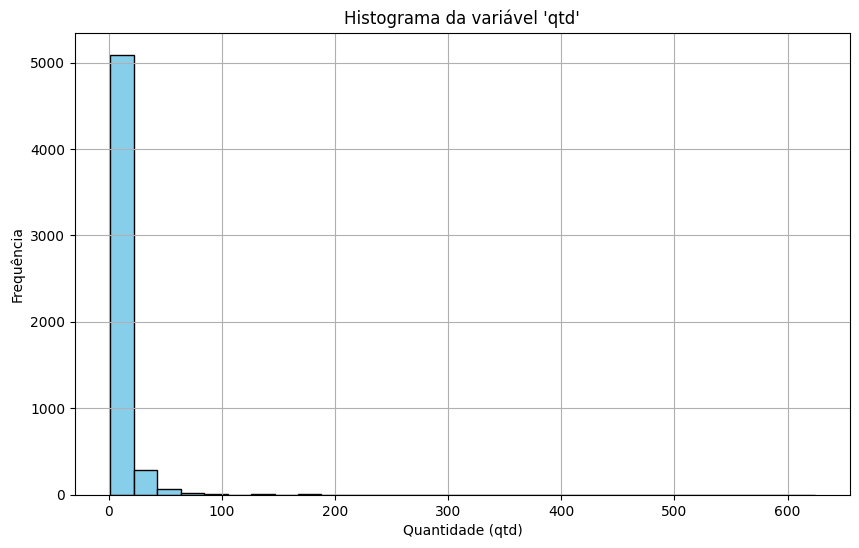

In [55]:
# Histograma - Quantidade de UBS por Município
plt.figure(figsize=(10, 6))
df_agrupado['qtd'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Histograma da variável 'qtd'")
plt.xlabel("Quantidade (qtd)")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()


In [56]:
#No histograma fica evidente a distribuição assimétrica, com uma cauda mais longa à direita

Limite inferior: -10.0
Limite superior: 22.0

Outliers abaixo do limite inferior:
Empty DataFrame
Columns: [IBGE, qtd, pop, mun_uf, uf, regiao]
Index: []

Outliers acima do limite superior:
        IBGE  qtd      pop                          mun_uf  uf        regiao
16    110020   60   460434                  Porto Velho/RO  RO         Norte
57    120020   29    91888              Cruzeiro do Sul/AC  AC         Norte
66    120040  106   364756                   Rio Branco/AC  AC         Norte
109   130260  255  2063689                       Manaus/AM  AM         Norte
119   130353   23    30668        Presidente Figueiredo/AM  AM         Norte
...      ...  ...      ...                             ...  ..           ...
5446  521975   23    72127  Santo Antônio do Descoberto/GO  GO  Centro-Oeste
5457  522045   24   155635               Senador Canedo/GO  GO  Centro-Oeste
5466  522140   32   142431                     Trindade/GO  GO  Centro-Oeste
5474  522185   39   198861          Valp

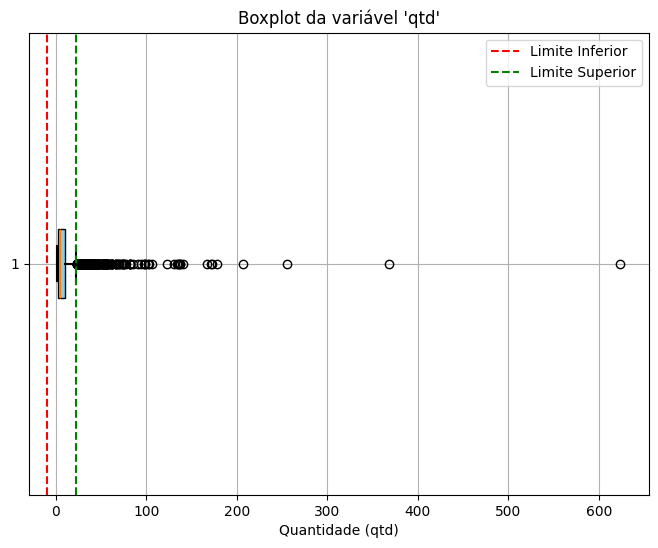

In [57]:
# Wuartis e o IQR
Q1 = df_agrupado['qtd'].quantile(0.25)
Q3 = df_agrupado['qtd'].quantile(0.75)
IQR = Q3 - Q1

# Limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Valores fora dos limites (outliers) ou extremos
outliers_abaixo = df_agrupado[df_agrupado['qtd'] < limite_inferior]
outliers_acima = df_agrupado[df_agrupado['qtd'] > limite_superior]

# Resultados dos limites e dos outliers
print(f"Limite inferior: {limite_inferior}")
print(f"Limite superior: {limite_superior}")
print(f"\nOutliers abaixo do limite inferior:\n{outliers_abaixo}")
print(f"\nOutliers acima do limite superior:\n{outliers_acima}")

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df_agrupado['qtd'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='skyblue', color='black'),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5))

# Linhas para o limite inferior e superior
plt.axvline(limite_inferior, color='red', linestyle='--', label='Limite Inferior')
plt.axvline(limite_superior, color='green', linestyle='--', label='Limite Superior')

# Título e rótulos
plt.title("Boxplot da variável 'qtd'")
plt.xlabel("Quantidade (qtd)")
plt.grid(True)

# legenda
plt.legend()

# Mostrar o gráfico
plt.show()


In [58]:
#Apesar de ter identificado os casos extremos, eles não serão retirados da base.

In [59]:
# Intervalos de quantidade com as novas faixas
bins = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 22, 25, 28, 31, float('inf')]  # Novas faixas
labels = ['0 a 1', '2 a 3', '4 a 5', '6 a 7', '8 a 9', '10 a 11', '12 a 13', '14 a 15', '16 a 17', 
          '18 a 19', '20 a 22', '23 a 25', '26 a 28', '29 a 31', 'Acima de 32']  # Novos rótulos

# Coluna de faixas de quantidade
df_agrupado['faixa_qtd'] = pd.cut(df_agrupado['qtd'], bins=bins, labels=labels, right=True)

# Frequência de cada faixa
frequencia = df_agrupado['faixa_qtd'].value_counts().sort_index()

# Tabela de frequência
tabela_frequencia = frequencia.reset_index()
tabela_frequencia.columns = ['Faixa', 'Frequência']

# Linha de total
total_frequencia = frequencia.sum()

linha_total = pd.DataFrame({'Faixa': ['Total'], 'Frequência': [total_frequencia]})

# Concatenar a linha de total ao final da tabela
tabela_frequencia = pd.concat([tabela_frequencia, linha_total], ignore_index=True)

# Exibir a tabela formatada
print(tabela_frequencia)

          Faixa  Frequência
0         0 a 1         742
1         2 a 3        1346
2         4 a 5         871
3         6 a 7         640
4         8 a 9         501
5       10 a 11         313
6       12 a 13         230
7       14 a 15         172
8       16 a 17         110
9       18 a 19          89
10      20 a 22         108
11      23 a 25          74
12      26 a 28          48
13      29 a 31          53
14  Acima de 32         185
15        Total        5482


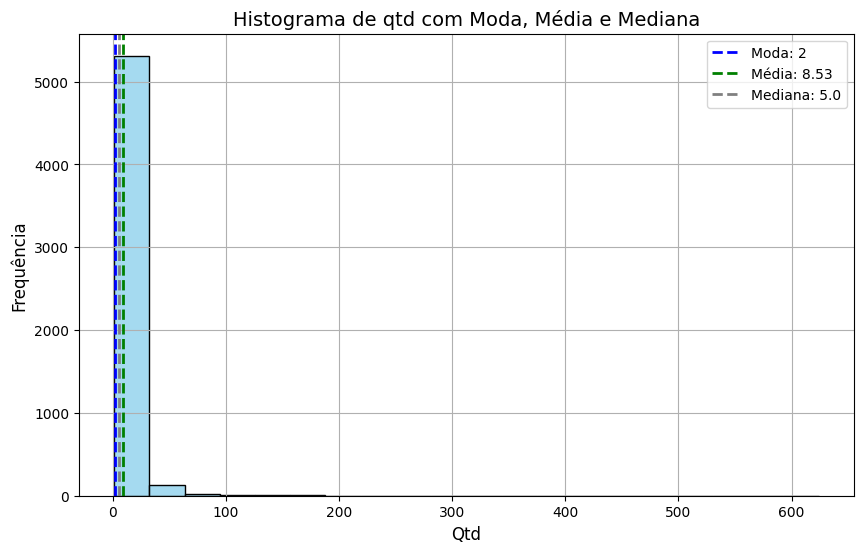

In [63]:
qtd = df_agrupado["qtd"]

# Moda, média e mediana
moda = qtd.mode()[0]  # Moda
media = qtd.mean()    # Média
mediana = qtd.median()  # Mediana

# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(qtd, kde=False, bins=20, color='skyblue', edgecolor='black')

# Linhas verticais para Moda, Média e Mediana
plt.axvline(moda, color='blue', linestyle='dashed', linewidth=2, label=f'Moda: {moda}')
plt.axvline(media, color='green', linestyle='dashed', linewidth=2, label=f'Média: {media:.2f}')
plt.axvline(mediana, color='gray', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana}')

# Títulos e rótulos
plt.title('Histograma de qtd com Moda, Média e Mediana', fontsize=14)
plt.xlabel('Qtd', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Legenda
plt.legend()

# Exibindo o gráfico
plt.grid(True)
plt.show()


In [60]:
#No histograma, boxspot e tabela de frequência, é possível perceber claramente a distribuição assimétrica.
#Como já falando antes, por se tratar de dados reais de UBS no Brasil, não vamos tratar como outlier os valores discrepantes, pois posteriormente vou fazer uma correlação com a quantidade de pessoas por município.
#O Brasil é um país com muitos municípios e com uma grande extensão.

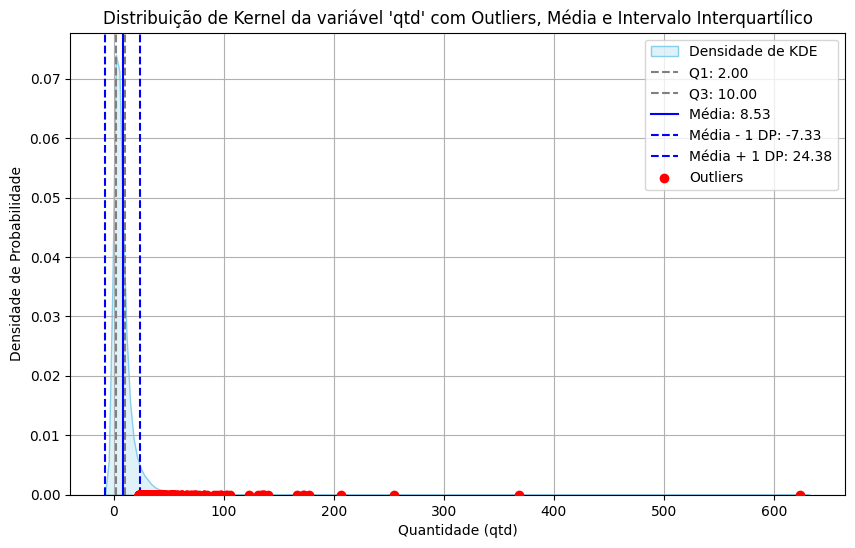

In [66]:
# Q1 (1º quartil), Q3 (3º quartil), média e desvio padrão
Q1 = df_agrupado['qtd'].quantile(0.25)
Q3 = df_agrupado['qtd'].quantile(0.75)
media = df_agrupado['qtd'].mean()
desvio_padrao = df_agrupado['qtd'].std()

# Intervalo interquartílico (IQR)
IQR = Q3 - Q1

# Limites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Outliers
outliers = df_agrupado[(df_agrupado['qtd'] < limite_inferior) | (df_agrupado['qtd'] > limite_superior)]

# Gráfico de dispersão KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(df_agrupado['qtd'], fill=True, color="skyblue", label="Densidade de KDE")

# Sinalizar o IQR (Q1 e Q3) com linhas verticais cinzas
plt.axvline(Q1, color="gray", linestyle="--", label=f"Q1: {Q1:.2f}")
plt.axvline(Q3, color="gray", linestyle="--", label=f"Q3: {Q3:.2f}")

# Sinalizar a média e o desvio padrão com linhas verticais azuis
plt.axvline(media, color="blue", linestyle="-", label=f"Média: {media:.2f}")
plt.axvline(media - desvio_padrao, color="blue", linestyle="--", label=f"Média - 1 DP: {media - desvio_padrao:.2f}")
plt.axvline(media + desvio_padrao, color="blue", linestyle="--", label=f"Média + 1 DP: {media + desvio_padrao:.2f}")

# Marcar os outliers com pontos vermelhos
plt.scatter(outliers['qtd'], np.zeros_like(outliers['qtd']), color='red', label='Outliers', zorder=5)

# Personalização do gráfico
plt.title("Distribuição de Kernel da variável 'qtd' com Outliers, Média e Intervalo Interquartílico")
plt.xlabel("Quantidade (qtd)")
plt.ylabel("Densidade de Probabilidade")
plt.legend()
plt.grid(True)
plt.show()


In [67]:
#Nesse gráfico, também é possível perceber
#A densidade de probabilidade está altamente concentrada próxima a valores baixos (perto de 0).
#Há uma cauda longa à direita, indicando uma distribuição assimétrica positiva (com alguns valores muito altos).
#A presença de outliers (pontos vermelhos) sugere que alguns valores são excepcionalmente grandes em relação ao restante dos dados.
#A quantidade de UBS por município apresenta uma distribuição assimétrica à direita, com muitos valores pequenos e poucos valores muito grandes.
#A média pode não ser um bom indicador central devido à influência dos valores extremos.

In [68]:
# Assimetria (skewness) e a curtose (kurtosis)
assimetria = df_agrupado['qtd'].skew()
curtose = df_agrupado['qtd'].kurt()

# Exibir os resultados
print(f"Assimetria (skewness) da variável 'qtd': {assimetria:.2f}")
print(f"Curtose (kurtosis) da variável 'qtd': {curtose:.2f}")


Assimetria (skewness) da variável 'qtd': 16.26
Curtose (kurtosis) da variável 'qtd': 493.20


In [69]:
#A assimetria é positiva e muito alta. 
#Isso significa que a distribuição é altamente assimétrica à direita, ou seja, a cauda da distribuição está muito mais alongada à direita. 
#Esse valor muito alto sugere que a maioria dos dados está concentrada em valores baixos, mas há alguns valores extremamente grandes que puxam a cauda da distribuição para a direita.

#A curtose é extremamente alta e positiva. 
#Isso indica que a distribuição tem caudas extremamente pesadas (muitas observações distantes da média). 
#A distribuição tem picos muito altos e caudas longas, o que sugere a presença de valores extremos.

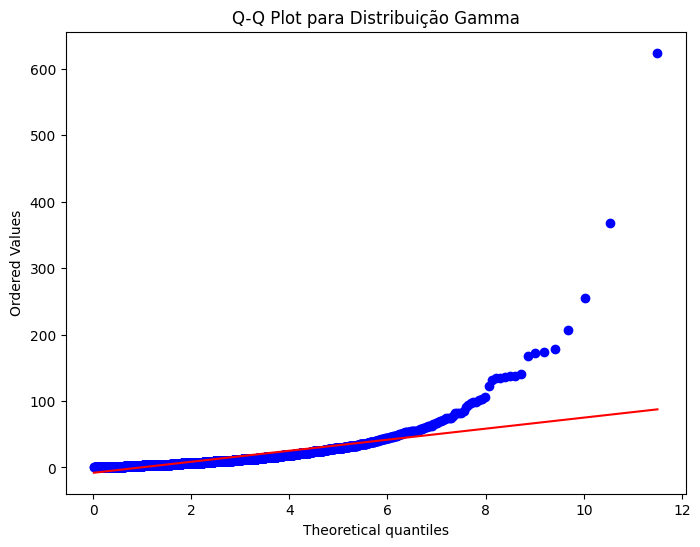

In [33]:
# Q-Q plot para verificar distribuição Gamma
plt.figure(figsize=(8, 6))
stats.probplot(df_agrupado['qtd'], dist="gamma", sparams=(2,), plot=plt)
plt.title("Q-Q Plot para Distribuição Gamma")
plt.show()

In [70]:
#A distribuição Gamma pode ser um bom ajuste para os dados na parte central da distribuição.
#No entanto, a presença de muitos valores extremos sugere que pode haver outliers ou uma assimetria mais acentuada do que o esperado.

Parâmetros ajustados para a distribuição Log-Normal: (np.float64(12.9049105338056), np.float64(0.9999999999999998), np.float64(0.029650335499450627))


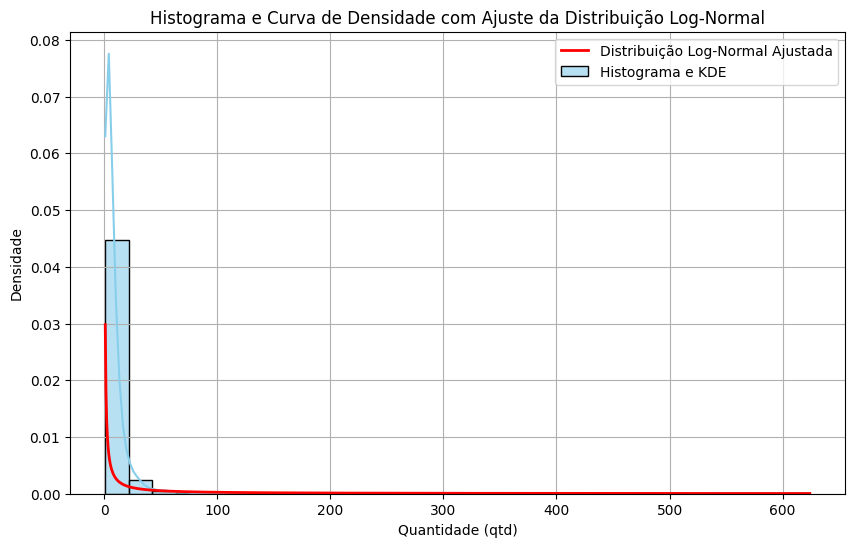

In [73]:
# Ajuste para a Distribuição Log-Normal
params_lognormal = stats.lognorm.fit(df_agrupado['qtd'])
print(f"Parâmetros ajustados para a distribuição Log-Normal: {params_lognormal}")

# Distribuição Log-Normal
shape, loc, scale = 12.90, 0.00, 0.03  # Usando os valores ajustados para a distribuição

# Gerar a distribuição Log-Normal ajustada
x = np.linspace(min(df_agrupado['qtd']), max(df_agrupado['qtd']), 1000)
lognorm_dist = lognorm.pdf(x, shape, loc=loc, scale=scale)

# Plotando o histograma e a densidade de Kernel dos dados
plt.figure(figsize=(10, 6))
sns.histplot(df_agrupado['qtd'], kde=True, color="skyblue", stat="density", bins=30, label="Histograma e KDE", alpha=0.6)

# Plotando a distribuição Log-Normal ajustada
plt.plot(x, lognorm_dist, color="red", label="Distribuição Log-Normal Ajustada", linewidth=2)

# Customizações do gráfico
plt.title("Histograma e Curva de Densidade com Ajuste da Distribuição Log-Normal")
plt.xlabel("Quantidade (qtd)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()


In [74]:
#A linha vermelha representa a distribuição Log-Normal ajustada aos dados.
#O ajuste parece capturar bem a forma da distribuição dos dados, confirmando que a variável segue um padrão log-normal.

#O comportamento do histograma reforça que os dados têm uma cauda longa com alguns valores extremos.
#Isso indica que medidas como a média podem ser influenciadas por esses valores altos, tornando a mediana uma estatística mais robusta para análise central.

#Pode-se dizer que a quantidade de UBS por município segue uma distribuição fortemente assimétrica e positiva, com uma boa aderência à distribuição Log-Normal.

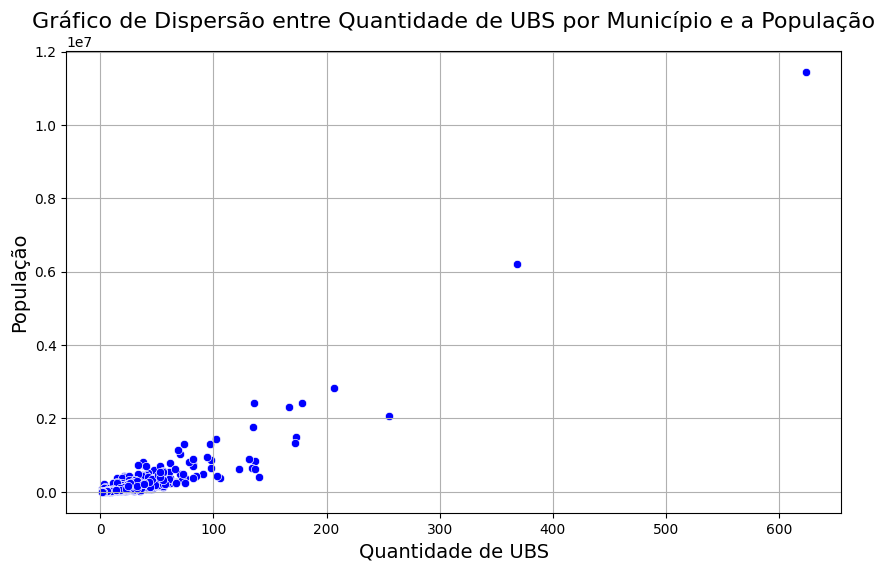

In [77]:
# Gráfico de dispersão (scatter plot) entre as variáveis 'qtd' e 'pop'
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_agrupado, x='qtd', y='pop', color='blue', marker='o')

# Adicionar título e rótulos
plt.title("Gráfico de Dispersão entre Quantidade de UBS por Município e a População", fontsize=16)
plt.xlabel("Quantidade de UBS", fontsize=14)
plt.ylabel("População", fontsize=14)

# Exibir o gráfico
plt.grid(True)
plt.show()

In [78]:
#O gráfico de dispersão indica que é possível ter uma correlação entre a quantidade de ubs por município e a população do município.

In [79]:
# Correlação de Pearson
correlacao_pearson, p_pearson = stats.pearsonr(df_agrupado['qtd'], df_agrupado['pop'])

# Correlação de Spearman
correlacao_spearman, p_spearman = stats.spearmanr(df_agrupado['qtd'], df_agrupado['pop'])

# Coeficiente de Determinação (R²)
r_quadrado = correlacao_pearson**2

# Exibir os resultados
print(f"Correlação de Pearson: {correlacao_pearson:.4f}")
print(f"Valor p da correlação de Pearson: {p_pearson:.4f}")
print(f"Correlação de Spearman: {correlacao_spearman:.4f}")
print(f"Valor p da correlação de Spearman: {p_spearman:.4f}")
print(f"Coeficiente de Determinação (R²): {r_quadrado:.4f}")

# Interpretando os resultados
if p_pearson < 0.05:
    print("A correlação de Pearson é significativa.")
else:
    print("A correlação de Pearson não é significativa.")
    
if p_spearman < 0.05:
    print("A correlação de Spearman é significativa.")
else:
    print("A correlação de Spearman não é significativa.")


Correlação de Pearson: 0.8724
Valor p da correlação de Pearson: 0.0000
Correlação de Spearman: 0.8734
Valor p da correlação de Spearman: 0.0000
Coeficiente de Determinação (R²): 0.7610
A correlação de Pearson é significativa.
A correlação de Spearman é significativa.


In [80]:
#A correlação de Pearson de 0.8541 indica uma forte correlação positiva, ou seja, à medida que a população aumenta, a quantidade de UBS também tende a aumentar.

#A correlação de Spearman de 0.8626 também sugere uma forte associação entre as variáveis, mas, ao contrário de Pearson, ela mede a relação monotônica (não necessariamente linear). 
#Este valor sugere que, independentemente de ser uma relação linear ou não, as variáveis estão fortemente associadas.

#Há uma forte correlação positiva entre as variáveis, tanto em uma relação linear (correlação de Pearson) quanto monotônica (correlação de Spearman).
#Ambas as correlações são estatisticamente significativas, pois os valores p são menores que 0.05.

#O coeficiente de determinação de 0.7294 significa que 72.94% da variação na quantidade de UBS pode ser explicada pela variação da população. 
#Esse valor é bastante alto, indicando que a população tem um impacto considerável na quantidade de UBS.

In [82]:
# Coeficiente de Correlação de Kendall (Tau de Kendall)
tau, p_value = kendalltau(df_agrupado['qtd'], df_agrupado['pop'])

# Exibir o resultado
print(f"Coeficiente de Correlação de Kendall (Tau de Kendall): {tau}")
print(f"Valor p: {p_value}")


Coeficiente de Correlação de Kendall (Tau de Kendall): 0.7254698373049459
Valor p: 0.0


In [83]:
#Existe uma correlação significativa e positiva entre as variáveis, com uma força moderada a forte, conforme indicado pelo Coeficiente de Kendall (Tau de Kendall).

#A correlação é estatisticamente relevante, dado que o valor p é muito baixo (próximo de zero).

In [85]:
# Covariância
covariancia = df_agrupado['qtd'].cov(df_agrupado['pop'])

# Exibir o valor da covariância
print(f"Covariância entre as variáveis: {covariancia}")

Covariância entre as variáveis: 2878308.1179190823


In [87]:
#Isso indica uma relação positiva entre as duas variáveis, o que significa que, de maneira geral, quando a qtd de UBS aumenta, a variável popolução também tende a aumentar, e vice-versa.

In [90]:
#Tendo os resultados estatísticos acima, é possível inferir que em municípios maiores há uma maior quantidade de UBS, como pode ser percebido nos municípios de São Paulo e Rio de Janeiro. Esses, entre outros, são os valores extremos apontados nos resultados acima.
#A cauda longa a direita mostra que há muitos municípios com baixa população e poucas UBSs.

#Esse estudo vai poder apoiar etapas posteriores do estudo que irá elaborar um modelo que priorize ou identique os locais mais necessitados de uma implantação de uma nova UBS. 